In [ ]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import xgboost
warnings.filterwarnings('ignore')
np.random.seed(32)
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, make_scorer, recall_score, ConfusionMatrixDisplay, accuracy_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Diabetes dataset - feature engineering and modeling

**Warning!**

The code runs for like 30 minutes. Start all cells at the beginning or you'll have to wait for them to run later on.

In [104]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [105]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [106]:
X_train.head()
len(X_train)

49000

This function splits text fragments from the clinical notes column. From exploratory data analysis (EDA), we identified 26 unique fragments. We assume that the hospital or clinic using our model will have a predefined choice list containing these 26 possible inputs. To convert this categorical data into numerical format, we apply one-hot encoding, creating separate binary columns for each fragment.

In [107]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

From EDA, we identified outliers in the BMI column. We decided to cap all values above 50 at 50, as this represents severe obesity in our analysis.

In [108]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

One-hot encoding of clinical notes created new columns, some of which were highly correlated with our existing features. We identified these correlations using a correlation matrix. To address this, we implemented a function that removes columns with a correlation higher than 0.95.

In [109]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

# Data Preprocessing Pipeline Overview

This pipeline performs several steps to transform the raw input data into a format suitable for machine learning modeling. Here’s a detailed breakdown:

1. **Dropping Unnecessary Columns**
   - Columns Dropped: 'year', 'location', and any column whose name starts with 'race'. From EDA we concluded that they will not be relevant to our model.  
2. **Feature Grouping**
   - Binary Features: e.g., 'hypertension', 'heart_disease'.
   - Numerical Features: e.g., 'age', 'bmi', 'hbA1c_level', 'blood_glucose_level' 
   - Categorical Features: e.g., 'gender'.  
3. **Clipping BMI Values**  
   - Removing outliers from bmi values.  
4. **Preprocessor1 – ColumnTransformer for Numerical Scaling and Dropping Columns**  
   - Drops the specified columns: 'year', 'location', 'race'.  
   - Scales the numerical features using.
5. **Preprocessor2 – ColumnTransformer for One-Hot Encoding and Custom Binarization**  
   - One-hot encodes 'gender' and 'smoking_history'.  
   - Creating new columns for 'clinical notes'.    
6. **High Correlation Removal**  
   - After all transformations, removing columns with a correlation higher than 0.95 in order to recude redundancy.  
7. **Final Output**  
   - `X_train_transformed_df` and `X_test_transformed_df` are DataFrames with the final set of features after applying all preprocessing steps.

Some changes we tried but didn't end up using:  
- dimensionality reduction by removing some smoking categories - gave worse results
- onehoting location - it gave worse or similar results, but we got additional 54 new columns which means high dimensionality
- frequency encoding location - it gave worse or similar results
- including race - similar results as above

Below are 2 classes we used for testing the changes above (we don't use them now)

In [110]:
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.freq_map = None

    def fit(self, X, y=None):
        self.freq_map = X[self.column].value_counts() / len(X)
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].map(self.freq_map).fillna(0)
        return X_copy[[self.column]]
    def get_feature_names_out(self, input_features=None):
        # Zwracamy nazwę kolumny, którą zamieniamy na częstotliwość
        return [f'{self.column}_freq']

In [155]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

We changed the types of features from objects to numeric.

In [160]:
X_train_transformed_df = X_train_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
X_test_transformed_df = X_test_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))

A correlation matrix after the changes our pipeline has applied.

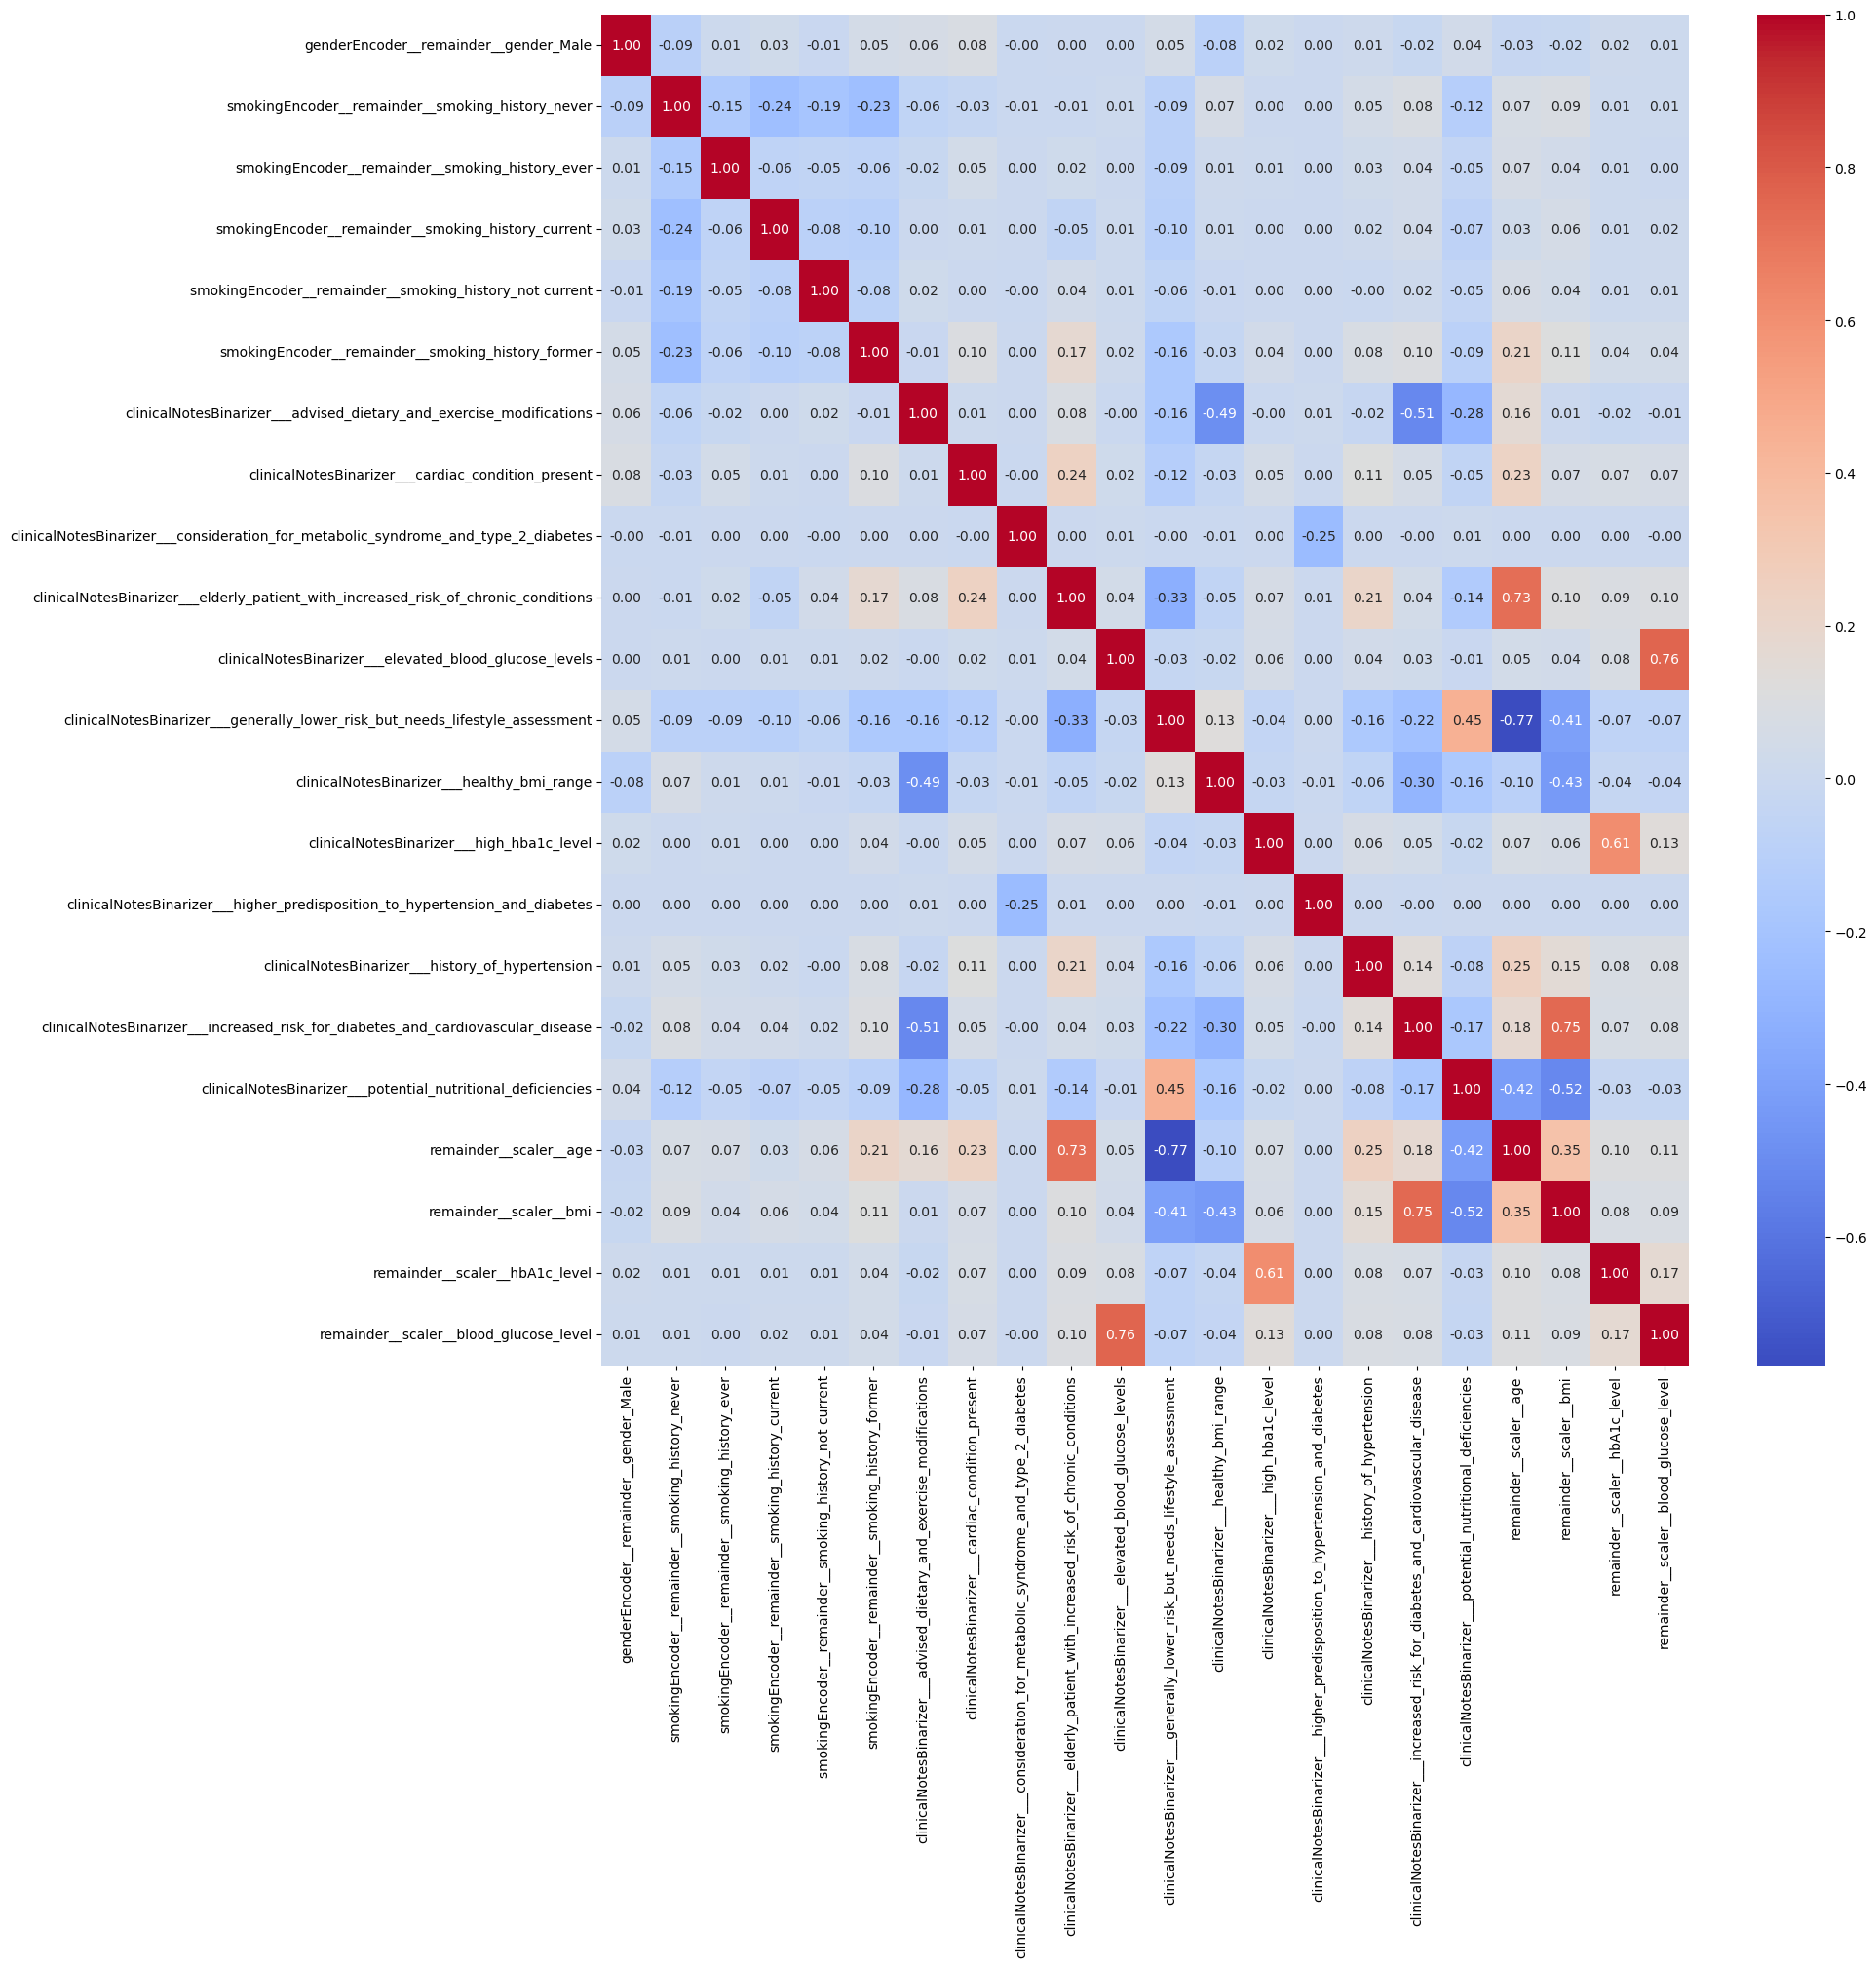

In [114]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

To make modelling easier we wrote a function which fit and predicts y_train and y_test. Then we use some metrics to evaluate the results.  
The metrics we use:  
- recall  
- F2
- pr_auc
- roc_auc
- accuracy
- confusion matrix
- specificity.

As stated in our business goal we want to put more emphasis on not missing people with diabetes. It's more damaging to miss an existing diabetes than to detect not present diabetes. That's why we want to maximise recall, but that often leads to predicting high number of false positives which can be expensive and also have negative implications. The key is to maintain a reasonable balance between high recall, F2 score and other metrics.

In [115]:
def specificity_score(cm):
    tn, fp, fn, tp = cm.ravel() 
    return tn / (tn + fp)

In [116]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1] 
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  
    test_pr_auc = auc(recall_test, precision_test)  
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm_train = confusion_matrix(y_train, y_train_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
    train_specificity = specificity_score(cfm_train)
    test_specificity = specificity_score(cfm)
    
    print("\nModel Performance:")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print(f"Training F2 Score: {train_f2:.4f}")
    print(f"Test F2 Score: {test_f2:.4f}")
    print(f"Training Specificity Score: {train_specificity:.4f}")
    print(f"Test Specificity Score: {test_specificity:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_recall, test_recall, train_f2, test_f2, train_prec, test_prec, train_specificity, test_specificity)

We tested several models and adjusted their hyperparameters to achieve the best results. Some models performed poorly, while others delivered great results.

**Logistic Regression**


Model Performance:
Training Recall Score: 0.6291
Test Recall Score: 0.6336
Training F2 Score: 0.6678
Test F2 Score: 0.6719
Training Specificity Score: 0.9925
Test Specificity Score: 0.9924
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training Accuracy Score: 0.9616
Test Accuracy Score: 0.9619
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


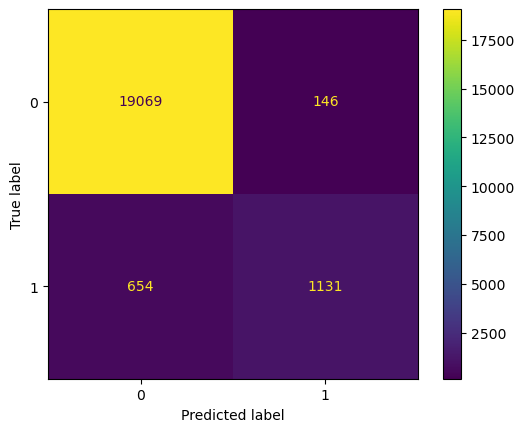

(0.810778737724598,
 0.8130076074145506,
 0.8254827428707748,
 0.8309939154416266,
 0.6290516206482593,
 0.6336134453781512,
 0.6678221859706363,
 0.671854580016633,
 0.9616122448979592,
 0.9619047619047619,
 0.9925058548009368,
 0.9924017694509498)

In [117]:
model = LogisticRegression(random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Training F2 Score: 0.7298
Test F2 Score: 0.7347
Training Specificity Score: 0.8873
Test Specificity Score: 0.8848
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


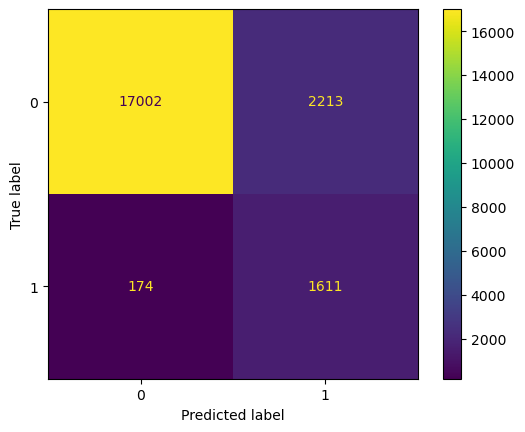

(0.8891248302599728,
 0.8936752843213788,
 0.8233054034123571,
 0.8289386583993921,
 0.8909963985594238,
 0.9025210084033614,
 0.7297648076771809,
 0.7346771251368114,
 0.8875714285714286,
 0.8863333333333333,
 0.8872532619605219,
 0.8848295602393963)

In [118]:
lr_best = LogisticRegression(class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, lr_best)

In [119]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']



Model Performance:
Training Recall Score: 0.8879
Test Recall Score: 0.8986
Training F2 Score: 0.7261
Test F2 Score: 0.7296
Training Specificity Score: 0.8861
Test Specificity Score: 0.8830
Training ROC-AUC: 0.8870
Test ROC-AUC: 0.8908
Training PR-AUC: 0.8199
Test PR-AUC: 0.8273
Training Accuracy Score: 0.8862
Test Accuracy Score: 0.8843
Test Confusion Matrix:
 [[16967  2248]
 [  181  1604]]


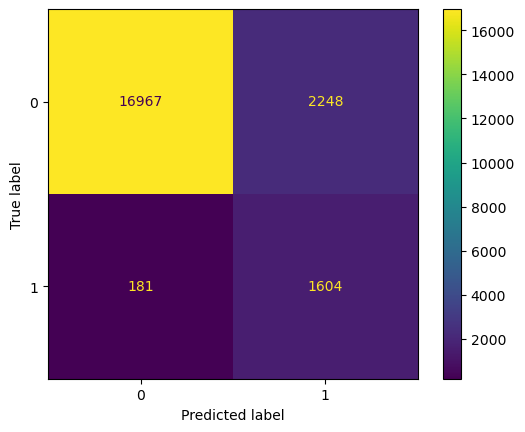

(0.8869843019174884,
 0.8908037531952671,
 0.8198885197689099,
 0.827260161369482,
 0.887875150060024,
 0.8985994397759104,
 0.7260946397015512,
 0.7296215429403202,
 0.8862448979591837,
 0.8843333333333333,
 0.8860934537749526,
 0.8830080666146239)

In [120]:
model = LogisticRegression(class_weight='balanced', random_state=32)
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training Recall Score: 0.8860
Test Recall Score: 0.8969
Training F2 Score: 0.7173
Test F2 Score: 0.7231
Training Specificity Score: 0.8802
Test Specificity Score: 0.8787
Training ROC-AUC: 0.8831
Test ROC-AUC: 0.8878
Training PR-AUC: 0.8148
Test PR-AUC: 0.8214
Training Accuracy Score: 0.8807
Test Accuracy Score: 0.8803
Test Confusion Matrix:
 [[16885  2330]
 [  184  1601]]


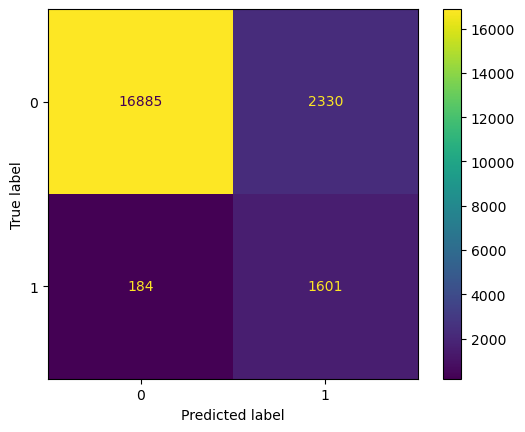

(0.883068637290982,
 0.88782966738608,
 0.8148046887663917,
 0.8214140922381276,
 0.885954381752701,
 0.8969187675070028,
 0.7172848145556333,
 0.7230602474934513,
 0.8806734693877551,
 0.8802857142857143,
 0.8801828928292629,
 0.8787405672651575)

In [121]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression(class_weight='balanced', random_state=32)
scores_model(X_train_sel, X_test_sel, model)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training Recall Score: 0.8896
Test Recall Score: 0.9020
Training F2 Score: 0.7292
Test F2 Score: 0.7342
Training Specificity Score: 0.8876
Test Specificity Score: 0.8847
Training ROC-AUC: 0.8886
Test ROC-AUC: 0.8933
Training PR-AUC: 0.8236
Test PR-AUC: 0.8294
Training Accuracy Score: 0.8878
Test Accuracy Score: 0.8862
Test Confusion Matrix:
 [[17000  2215]
 [  175  1610]]


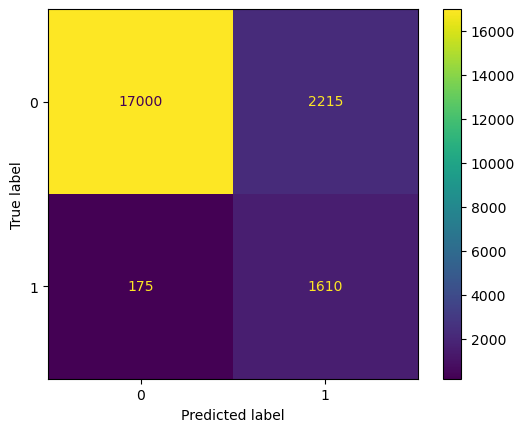

(0.8885718221714917,
 0.8933431296015674,
 0.8235551078869582,
 0.8293510344596808,
 0.8895558223289316,
 0.9019607843137255,
 0.7291871678803385,
 0.7341541267669859,
 0.8877551020408163,
 0.8861904761904762,
 0.8875878220140515,
 0.8847254748894093)

In [122]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)


Model Performance:
Training Recall Score: 0.8905
Test Recall Score: 0.9025
Training F2 Score: 0.7292
Test F2 Score: 0.7343
Training Specificity Score: 0.8871
Test Specificity Score: 0.8846
Training ROC-AUC: 0.8888
Test ROC-AUC: 0.8935
Training PR-AUC: 0.8233
Test PR-AUC: 0.8290
Training Accuracy Score: 0.8874
Test Accuracy Score: 0.8861
Test Confusion Matrix:
 [[16997  2218]
 [  174  1611]]


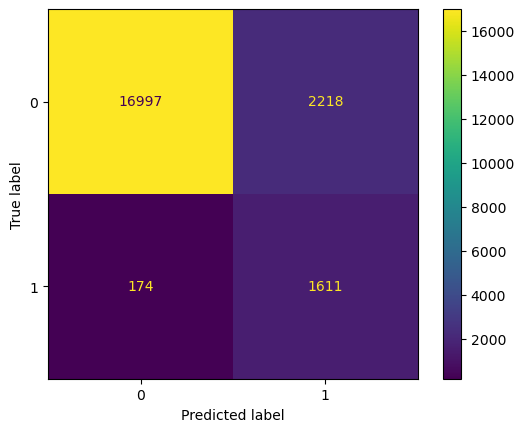

(0.8888066702090672,
 0.893545177633895,
 0.8233377305854888,
 0.8289891805488439,
 0.890516206482593,
 0.9025210084033614,
 0.7292281074279423,
 0.7343422372139666,
 0.8873877551020408,
 0.886095238095238,
 0.8870971339355415,
 0.8845693468644288)

In [123]:
model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

**KNN**


Model Performance:
Training Recall Score: 0.6106
Test Recall Score: 0.5838
Training F2 Score: 0.6577
Test F2 Score: 0.6288
Training Specificity Score: 0.9971
Test Specificity Score: 0.9946
Training ROC-AUC: 0.8038
Test ROC-AUC: 0.7892
Training PR-AUC: 0.8892
Test PR-AUC: 0.7988
Training Accuracy Score: 0.9642
Test Accuracy Score: 0.9597
Test Confusion Matrix:
 [[19112   103]
 [  743  1042]]


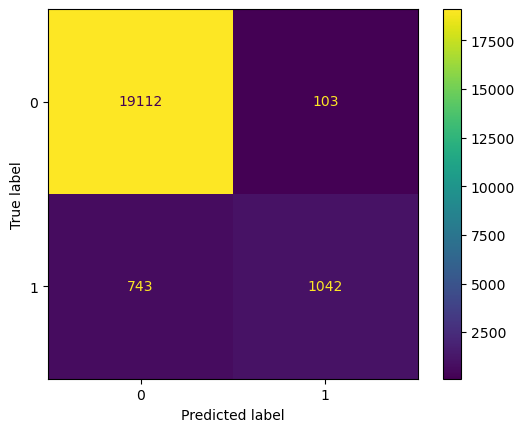

(0.8038323526131764,
 0.7891965529381152,
 0.8892429213467883,
 0.7987520894198481,
 0.6105642256902761,
 0.5837535014005603,
 0.6576837531681581,
 0.6288473144236573,
 0.9642448979591837,
 0.9597142857142857,
 0.9971004795360767,
 0.99463960447567)

In [124]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

**RandomisedSearchCV for DecisionTreeClassifier**

Best parameters: {'min_samples_split': 14, 'min_samples_leaf': 0.05, 'max_features': 8, 'max_depth': 4, 'criterion': 'entropy'}

Best model scores:

Model Performance:
Training Recall Score: 0.9806
Test Recall Score: 0.9787
Training F2 Score: 0.6040
Test F2 Score: 0.6055
Training Specificity Score: 0.7086
Test Specificity Score: 0.7118
Training ROC-AUC: 0.8446
Test ROC-AUC: 0.8452
Training PR-AUC: 0.5856
Test PR-AUC: 0.5830
Training Accuracy Score: 0.7317
Test Accuracy Score: 0.7345
Test Confusion Matrix:
 [[13677  5538]
 [   38  1747]]


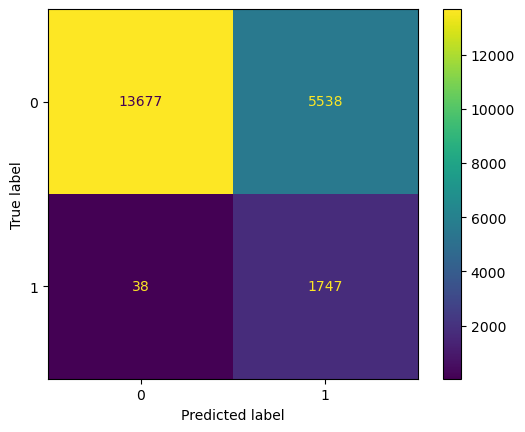

(0.8445752071320332,
 0.845249575239932,
 0.585551967722438,
 0.5830478170911129,
 0.9805522208883554,
 0.9787114845938375,
 0.6039811884409477,
 0.6055459272097053,
 0.7317142857142858,
 0.7344761904761905,
 0.708598193375711,
 0.7117876658860265)

In [125]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    "max_depth" : range(2, 20),
    "max_features" : range(2, 10),
    "min_samples_split" : range(2, 20),
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(class_weight='balanced', random_state=32)
scoring = {
    'roc_auc': 'roc_auc', 
    'pr_auc': make_scorer(pr_auc_scorer),
    'recall': 'recall' 
}

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='recall')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

dtc_best = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, dtc_best)

**Voting Classifier**

In [126]:
lr = LogisticRegression(class_weight='balanced', random_state=32)

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15, class_weight='balanced')

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Logistic Regression

Model Performance:
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Training F2 Score: 0.7298
Test F2 Score: 0.7347
Training Specificity Score: 0.8873
Test Specificity Score: 0.8848
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


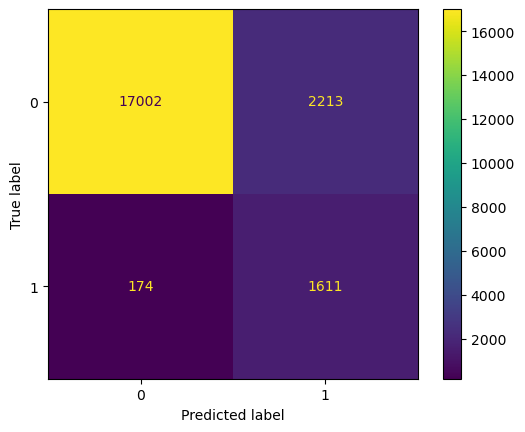

K Nearest Neighbours

Model Performance:
Training Recall Score: 0.5904
Test Recall Score: 0.5720
Training F2 Score: 0.6398
Test F2 Score: 0.6198
Training Specificity Score: 0.9978
Test Specificity Score: 0.9961
Training ROC-AUC: 0.7941
Test ROC-AUC: 0.7840
Training PR-AUC: 0.8813
Test PR-AUC: 0.8023
Training Accuracy Score: 0.9632
Test Accuracy Score: 0.9600
Test Confusion Matrix:
 [[19140    75]
 [  764  1021]]


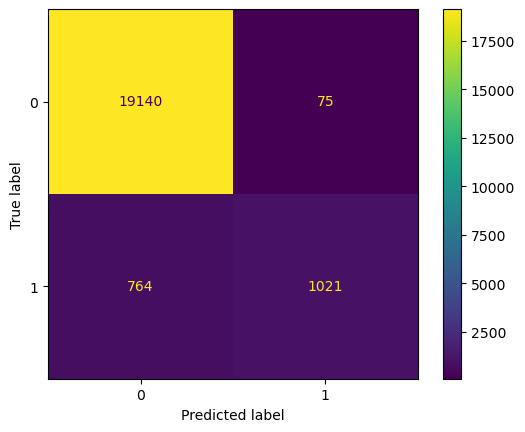

Classification Tree

Model Performance:
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Training F2 Score: 0.5696
Test F2 Score: 0.5691
Training Specificity Score: 0.7335
Test Specificity Score: 0.7363
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


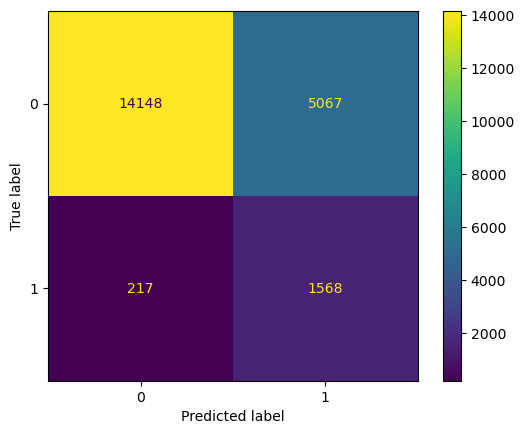


Model Performance:
Training Recall Score: 0.8435
Test Recall Score: 0.8246
Training F2 Score: 0.7672
Test F2 Score: 0.7505
Training Specificity Score: 0.9393
Test Specificity Score: 0.9378
Training ROC-AUC: 0.8914
Test ROC-AUC: 0.8812
Training PR-AUC: 0.8488
Test PR-AUC: 0.8250
Training Accuracy Score: 0.9312
Test Accuracy Score: 0.9282
Test Confusion Matrix:
 [[18020  1195]
 [  313  1472]]


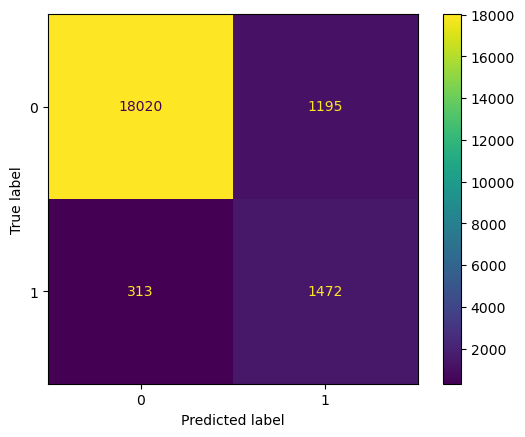

(0.8913840946214552,
 0.8812294316633756,
 0.8488106928380809,
 0.8249784431182627,
 0.8434573829531813,
 0.8246498599439775,
 0.7672315890626364,
 0.7504843479147547,
 0.9311632653061225,
 0.9281904761904762,
 0.939310806289729,
 0.9378090033827738)

In [127]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

**Random Forest Classifier**


Model Performance:
Training Recall Score: 0.9373
Test Recall Score: 0.8762
Training F2 Score: 0.8313
Test F2 Score: 0.7789
Training Specificity Score: 0.9350
Test Specificity Score: 0.9305
Training ROC-AUC: 0.9361
Test ROC-AUC: 0.9033
Training PR-AUC: 0.9290
Test PR-AUC: 0.8790
Training Accuracy Score: 0.9352
Test Accuracy Score: 0.9259
Test Confusion Matrix:
 [[17879  1336]
 [  221  1564]]


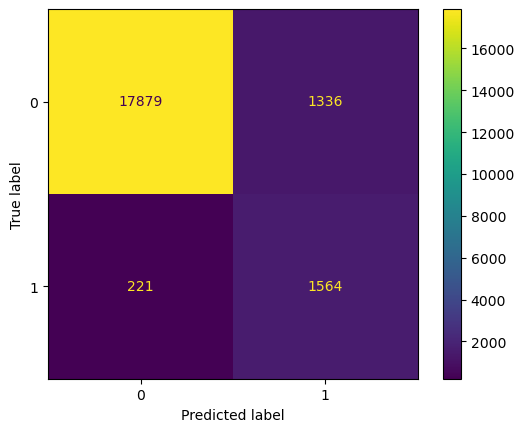

(0.9361482297837168,
 0.9033307311995836,
 0.9290044549690031,
 0.8789522996034062,
 0.9373349339735895,
 0.8761904761904762,
 0.8313458262350937,
 0.7788844621513944,
 0.9351632653061225,
 0.9258571428571428,
 0.934961525593844,
 0.9304709862086912)

In [128]:
rf = RandomForestClassifier(max_depth=13, class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training Recall Score: 0.9400
Test Recall Score: 0.8728
Training F2 Score: 0.8265
Test F2 Score: 0.7688
Training Specificity Score: 0.9307
Test Specificity Score: 0.9253
Training ROC-AUC: 0.9353
Test ROC-AUC: 0.8991
Training PR-AUC: 0.9266
Test PR-AUC: 0.8764
Training Accuracy Score: 0.9315
Test Accuracy Score: 0.9209
Test Confusion Matrix:
 [[17780  1435]
 [  227  1558]]


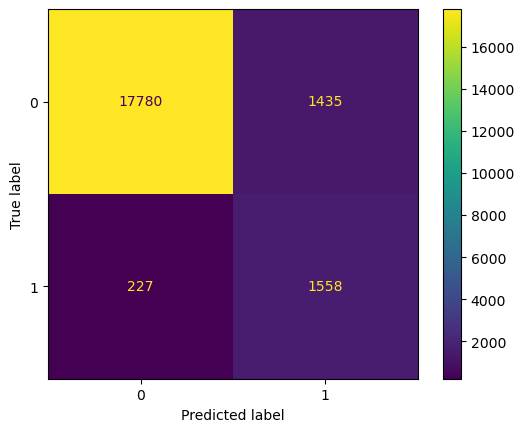

(0.9353275736524118,
 0.8990739465184981,
 0.9265858564842031,
 0.8764287473276133,
 0.9399759903961584,
 0.8728291316526611,
 0.8265422454925474,
 0.7687752886608112,
 0.931469387755102,
 0.9208571428571428,
 0.9306791569086651,
 0.9253187613843351)

In [129]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training Recall Score: 0.9438
Test Recall Score: 0.8689
Training F2 Score: 0.8414
Test F2 Score: 0.7771
Training Specificity Score: 0.9382
Test Specificity Score: 0.9329
Training ROC-AUC: 0.9410
Test ROC-AUC: 0.9009
Training PR-AUC: 0.9325
Test PR-AUC: 0.8762
Training Accuracy Score: 0.9387
Test Accuracy Score: 0.9275
Test Confusion Matrix:
 [[17926  1289]
 [  234  1551]]


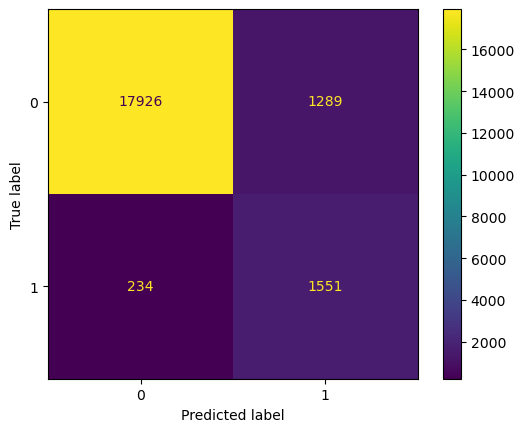

(0.941017718562835,
 0.9009122774792978,
 0.932457514029927,
 0.8762189681492286,
 0.9438175270108043,
 0.8689075630252101,
 0.8413595308420017,
 0.7770541082164328,
 0.9386938775510204,
 0.9274761904761905,
 0.9382179101148657,
 0.9329169919333854)

In [130]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training Recall Score: 0.9373
Test Recall Score: 0.8762
Training F2 Score: 0.8313
Test F2 Score: 0.7789
Training Specificity Score: 0.9350
Test Specificity Score: 0.9305
Training ROC-AUC: 0.9361
Test ROC-AUC: 0.9033
Training PR-AUC: 0.9290
Test PR-AUC: 0.8790
Training Accuracy Score: 0.9352
Test Accuracy Score: 0.9259
Test Confusion Matrix:
 [[17879  1336]
 [  221  1564]]


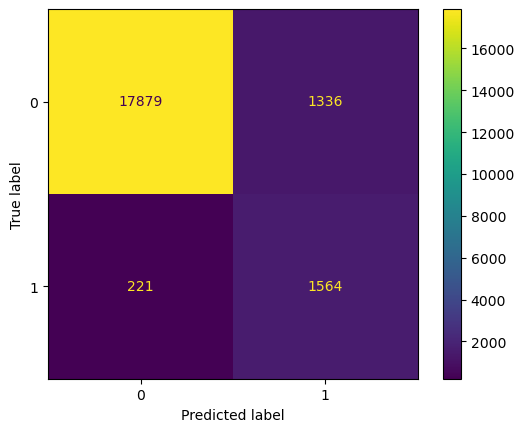

[0.00461668 0.00319805 0.00225188 0.00283178 0.0026464  0.00365644
 0.00352386 0.00987027 0.00346038 0.04337675 0.05677411 0.03325189
 0.00369558 0.0798884  0.00304121 0.01744381 0.02682035 0.00208854
 0.11587396 0.05626603 0.29770057 0.22772305]

Model Performance:
Training Recall Score: 0.9390
Test Recall Score: 0.8975
Training F2 Score: 0.7839
Test F2 Score: 0.7474
Training Specificity Score: 0.9024
Test Specificity Score: 0.8972
Training ROC-AUC: 0.9207
Test ROC-AUC: 0.8973
Training PR-AUC: 0.8921
Test PR-AUC: 0.8612
Training Accuracy Score: 0.9056
Test Accuracy Score: 0.8972
Test Confusion Matrix:
 [[17240  1975]
 [  183  1602]]


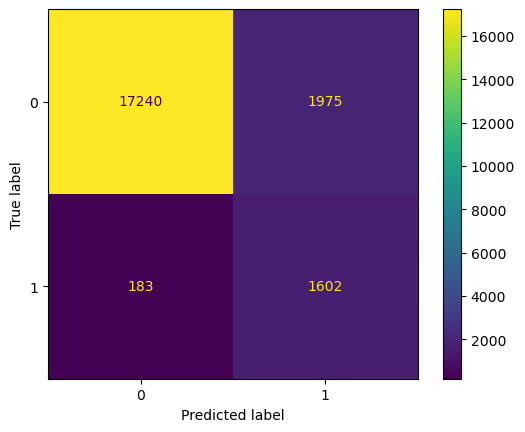

(0.9207289473166316,
 0.8973473542422433,
 0.8921237921640025,
 0.8612013161017683,
 0.939015606242497,
 0.8974789915966387,
 0.7839246341952295,
 0.747410655967155,
 0.9055510204081633,
 0.8972380952380953,
 0.9024422883907661,
 0.8972157168878481)

In [131]:
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)

Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.

Model Performance:
Training Recall Score: 0.9467
Test Recall Score: 0.8728
Training F2 Score: 0.8443
Test F2 Score: 0.7795
Training Specificity Score: 0.9387
Test Specificity Score: 0.9326
Training ROC-AUC: 0.9427
Test ROC-AUC: 0.9027
Training PR-AUC: 0.9329
Test PR-AUC: 0.8774
Training Accuracy Score: 0.9394
Test Accuracy Score: 0.9275
Test Confusion Matrix:
 [[17920  1295]
 [  227  1558]]


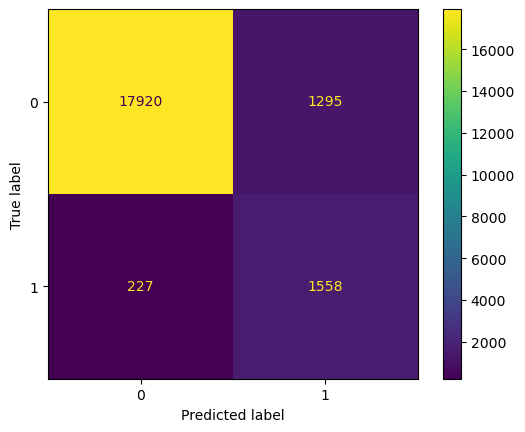

(0.9427147908343665,
 0.9027169337680427,
 0.9328599844999432,
 0.877379681976057,
 0.9466986794717888,
 0.8728291316526611,
 0.8443254817987152,
 0.7795456819773842,
 0.9394081632653061,
 0.9275238095238095,
 0.9387309021969443,
 0.9326047358834244)

In [132]:
rfe = RFE(estimator=rf, n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

[0.26026325 0.43996261 0.5796008  0.70175682 0.75437267 0.79355488
 0.82689059 0.85720648 0.87952059 0.89768802 0.91357461 0.92823281
 0.94141713 0.9541003  0.96523757 0.97465769 0.98210941 0.98733193
 0.99207206 0.99633129 1.         1.        ]


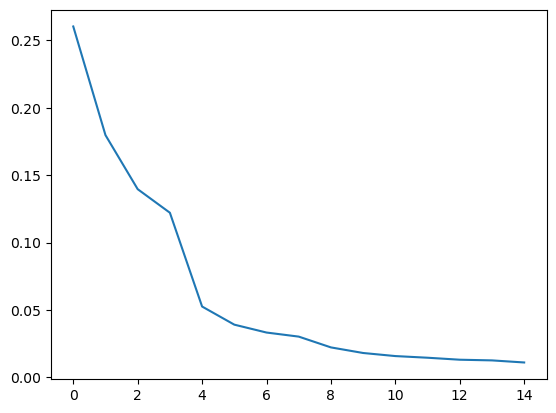

In [133]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', rf)
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)


Model Performance:
Training Recall Score: 0.9563
Test Recall Score: 0.8387
Training F2 Score: 0.8754
Test F2 Score: 0.7740
Training Specificity Score: 0.9530
Test Specificity Score: 0.9462
Training ROC-AUC: 0.9547
Test ROC-AUC: 0.8924
Training PR-AUC: 0.9374
Test PR-AUC: 0.8578
Training Accuracy Score: 0.9533
Test Accuracy Score: 0.9371
Test Confusion Matrix:
 [[18182  1033]
 [  288  1497]]


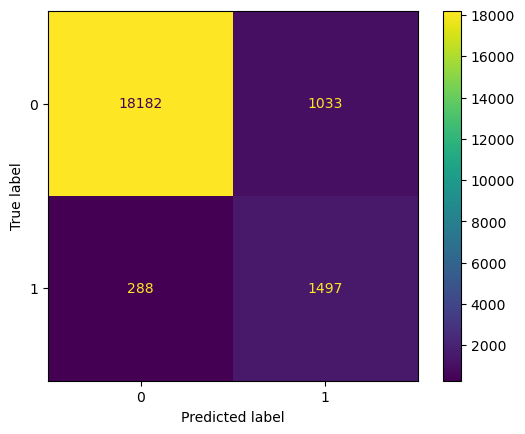

(0.9546651447464233,
 0.8924476894582971,
 0.9373615721566197,
 0.857757874000859,
 0.9563025210084034,
 0.838655462184874,
 0.8754230955206822,
 0.7740434332988625,
 0.9533061224489796,
 0.9370952380952381,
 0.9530277684844429,
 0.94623991673172)

In [134]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5, random_state=32)),
    ('classifier', rf)
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)

Best parameters: {'n_estimators': 52, 'min_samples_split': 10, 'max_features': 7, 'max_depth': 6}

Best model scores:

Model Performance:
Training Recall Score: 0.9229
Test Recall Score: 0.9255
Training F2 Score: 0.7436
Test F2 Score: 0.7458
Training Specificity Score: 0.8809
Test Specificity Score: 0.8811
Training ROC-AUC: 0.9019
Test ROC-AUC: 0.9033
Training PR-AUC: 0.8700
Test PR-AUC: 0.8798
Training Accuracy Score: 0.8844
Test Accuracy Score: 0.8849
Test Confusion Matrix:
 [[16931  2284]
 [  133  1652]]


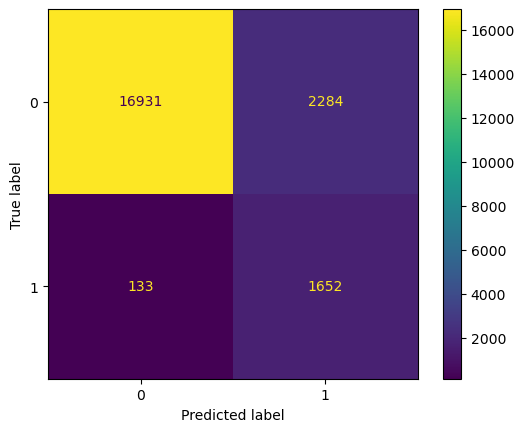

(0.9018905923024949,
 0.9033123631966449,
 0.8699684231203794,
 0.8797611742816895,
 0.9229291716686675,
 0.9254901960784314,
 0.7436353787820166,
 0.7457565908270134,
 0.8844285714285715,
 0.8849047619047619,
 0.8808520129363221,
 0.8811345303148582)

In [135]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : range(2, 10),
              "min_samples_split" : range(2, 20),
              "n_estimators" : range(2, 100, 10)}

scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer, random_state=32)

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

rf_best = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, rf_best)

**Bagging Classifier**


Model Performance:
Training Recall Score: 0.9184
Test Recall Score: 0.9244
Training F2 Score: 0.7468
Test F2 Score: 0.7515
Training Specificity Score: 0.8857
Test Specificity Score: 0.8861
Training ROC-AUC: 0.9020
Test ROC-AUC: 0.9053
Training PR-AUC: 0.8707
Test PR-AUC: 0.8800
Training Accuracy Score: 0.8885
Test Accuracy Score: 0.8894
Test Confusion Matrix:
 [[17027  2188]
 [  135  1650]]


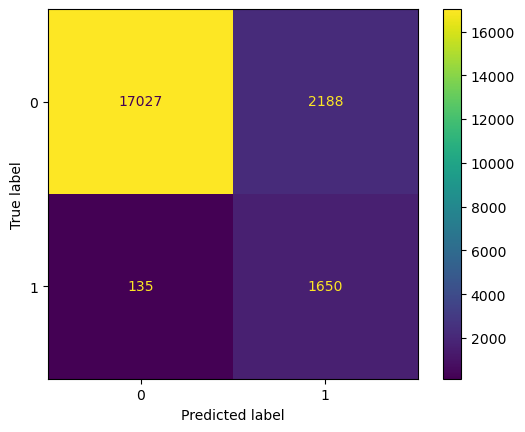

(0.9020296643247463,
 0.9052501875066967,
 0.870668377090263,
 0.8800403046685938,
 0.9183673469387755,
 0.9243697478991597,
 0.7467786021085513,
 0.751503006012024,
 0.8884693877551021,
 0.8893809523809524,
 0.8856919817107171,
 0.8861306271142336)

In [136]:
bagging_best = BaggingClassifier(estimator= rf_best,
                        n_estimators=15, random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, bagging_best)

**AdaBoost**


Model Performance:
Training Recall Score: 0.6639
Test Recall Score: 0.6930
Training F2 Score: 0.7117
Test F2 Score: 0.7383
Training Specificity Score: 1.0000
Test Specificity Score: 1.0000
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8679
Test PR-AUC: 0.8773
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


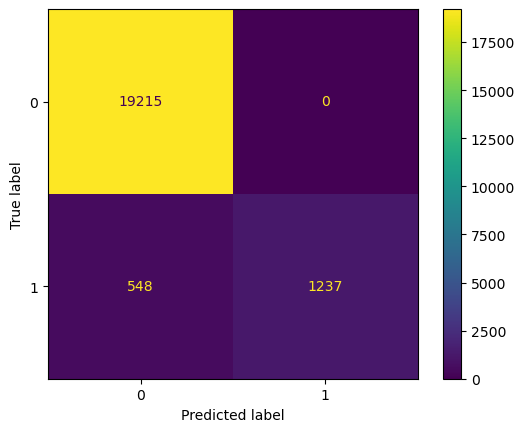

(0.8319327731092436,
 0.8464985994397759,
 0.8679404059139555,
 0.8773173872150284,
 0.6638655462184874,
 0.6929971988795518,
 0.7117117117117117,
 0.7383311448012415,
 0.9714285714285714,
 0.9739047619047619,
 1.0,
 1.0)

In [137]:
ada = AdaBoostClassifier(random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, ada)

**GBoost**


Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


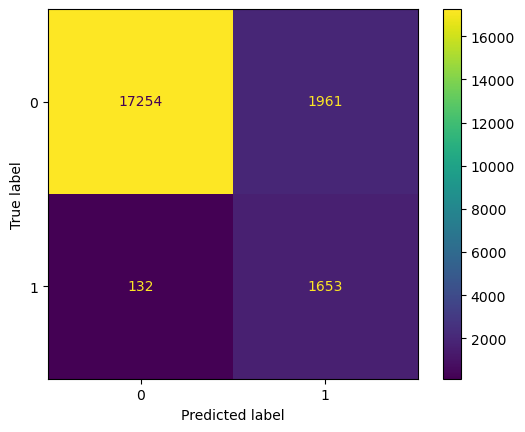

Best parameters: {'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 8}

Best model scores:

Model Performance:
Training Recall Score: 0.9330
Test Recall Score: 0.9350
Training F2 Score: 0.7509
Test F2 Score: 0.7506
Training Specificity Score: 0.8811
Test Specificity Score: 0.8798
Training ROC-AUC: 0.9071
Test ROC-AUC: 0.9074
Training PR-AUC: 0.8803
Test PR-AUC: 0.8859
Training Accuracy Score: 0.8855
Test Accuracy Score: 0.8845
Test Confusion Matrix:
 [[16906  2309]
 [  116  1669]]


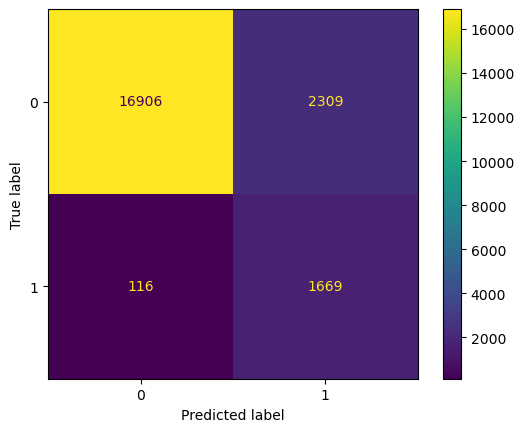

(0.907055281128845,
 0.9074237345211309,
 0.8803121361508686,
 0.885912797500148,
 0.9330132052821128,
 0.9350140056022409,
 0.7508598369208177,
 0.7505846375247347,
 0.8855102040816326,
 0.8845238095238095,
 0.8810973569755771,
 0.8798334634400208)

In [138]:
gboost_best = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, gboost_best)

param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20)}

scorer = make_scorer(recall_score)

random_search_boost = RandomizedSearchCV(estimator=gboost_best, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer, random_state=32)

random_search_boost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, boost_best)

**XGBoost**


Model Performance:
Training Recall Score: 0.9974
Test Recall Score: 0.8028
Training F2 Score: 0.9494
Test F2 Score: 0.7625
Training Specificity Score: 0.9763
Test Specificity Score: 0.9571
Training ROC-AUC: 0.9868
Test ROC-AUC: 0.8800
Training PR-AUC: 0.9932
Test PR-AUC: 0.8645
Training Accuracy Score: 0.9781
Test Accuracy Score: 0.9440
Test Confusion Matrix:
 [[18391   824]
 [  352  1433]]


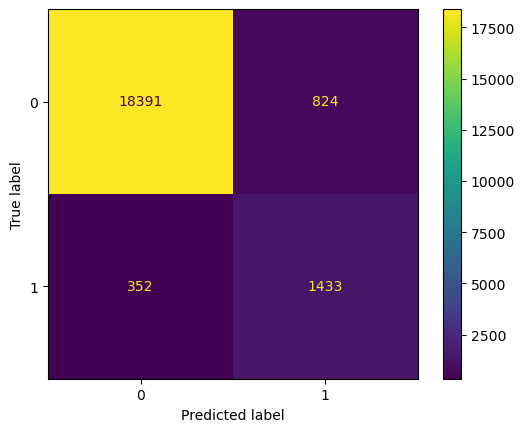


Model Performance:
Training Recall Score: 0.9188
Test Recall Score: 0.9255
Training F2 Score: 0.6552
Test F2 Score: 0.6570
Training Specificity Score: 0.8055
Test Specificity Score: 0.8033
Training ROC-AUC: 0.8622
Test ROC-AUC: 0.8644
Training PR-AUC: 0.7618
Test PR-AUC: 0.7645
Training Accuracy Score: 0.8151
Test Accuracy Score: 0.8137
Test Confusion Matrix:
 [[15435  3780]
 [  133  1652]]


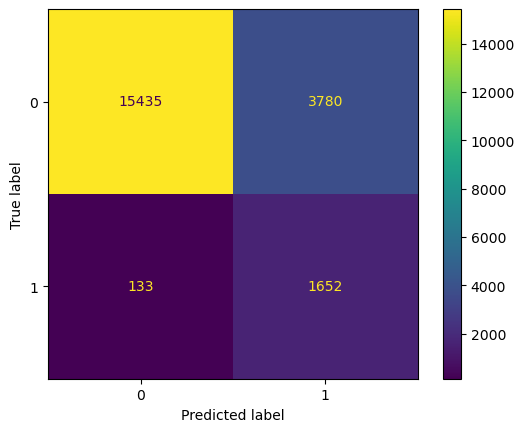

(0.8621783139485303,
 0.8643844423015108,
 0.7617775401917616,
 0.7644658747143733,
 0.9188475390156062,
 0.9254901960784314,
 0.6551511623925771,
 0.6570155902004454,
 0.8151428571428572,
 0.8136666666666666,
 0.8055090888814542,
 0.8032786885245902)

In [139]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gbtree',
                    max_depth=20,
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb)

xgb_best=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gblinear',
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb_best)

Best parameters: {'n_estimators': 130, 'min_child_weight': 9, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

Best model scores:

Model Performance:
Training Recall Score: 0.9352
Test Recall Score: 0.9305
Training F2 Score: 0.7560
Test F2 Score: 0.7521
Training Specificity Score: 0.8839
Test Specificity Score: 0.8834
Training ROC-AUC: 0.9096
Test ROC-AUC: 0.9070
Training PR-AUC: 0.8821
Test PR-AUC: 0.8848
Training Accuracy Score: 0.8883
Test Accuracy Score: 0.8874
Test Confusion Matrix:
 [[16974  2241]
 [  124  1661]]


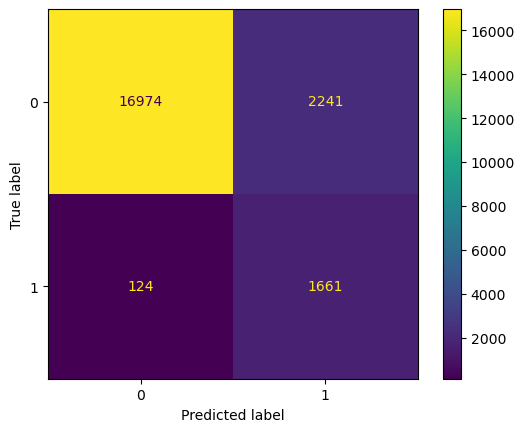

(0.9095520175283227,
 0.9069522891123663,
 0.8820863153928384,
 0.8848248513762562,
 0.9351740696278511,
 0.9305322128851541,
 0.7560464303738499,
 0.752128237638109,
 0.8882857142857142,
 0.8873809523809524,
 0.8839299654287944,
 0.8833723653395784)

In [140]:
xgb=XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight)

param_dist = {
    "max_depth": range(2, 20),
    "min_child_weight": range(1, 10),
    "n_estimators": range(10, 200, 10), 
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "booster": ["gbtree", "gblinear"]
}

random_search_xgboost = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer, random_state=32)

random_search_xgboost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_xgboost.best_params_)

best_model_xgboost = random_search_xgboost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model_xgboost)

**Gaussian Naive Bayes**


Model Performance:
Training Recall Score: 0.8439
Test Recall Score: 0.8510
Training F2 Score: 0.6608
Test F2 Score: 0.6638
Training Specificity Score: 0.8568
Test Specificity Score: 0.8552
Training ROC-AUC: 0.8504
Test ROC-AUC: 0.8531
Training PR-AUC: 0.5791
Test PR-AUC: 0.5782
Training Accuracy Score: 0.8557
Test Accuracy Score: 0.8549
Test Confusion Matrix:
 [[16433  2782]
 [  266  1519]]


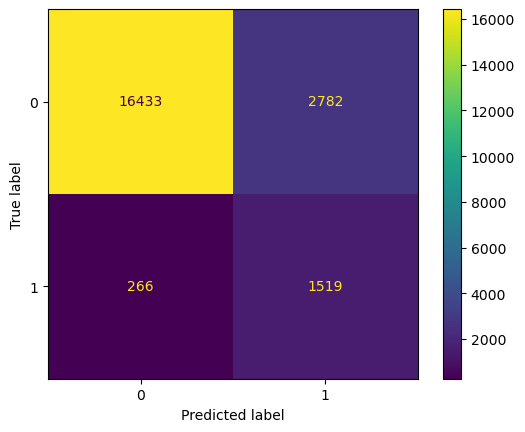

(0.8503617840578854,
 0.8530988351624802,
 0.5791326399852448,
 0.5781518468406931,
 0.843937575030012,
 0.8509803921568627,
 0.6608136561889005,
 0.6638405733764531,
 0.8556938775510204,
 0.8548571428571429,
 0.8567859930857589,
 0.8552172781680979)

In [141]:
bayes = GaussianNB()
scores_model(X_train_transformed_df, X_test_transformed_df, bayes)


Model Performance:
Training Recall Score: 0.9527
Test Recall Score: 0.9479
Training F2 Score: 0.5432
Test F2 Score: 0.5395
Training Specificity Score: 0.6455
Test Specificity Score: 0.6435
Training ROC-AUC: 0.7991
Test ROC-AUC: 0.7957
Training PR-AUC: 0.5790
Test PR-AUC: 0.5782
Training Accuracy Score: 0.6716
Test Accuracy Score: 0.6694
Test Confusion Matrix:
 [[12365  6850]
 [   93  1692]]


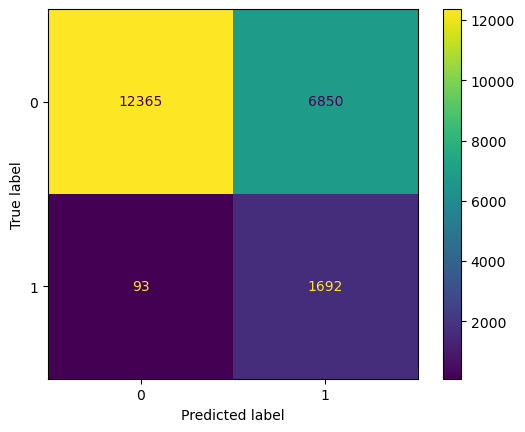

(0.7990783198525311,
 0.7957034179792135,
 0.5790397777086045,
 0.5781992335986269,
 0.9527010804321728,
 0.9478991596638655,
 0.5432044682948198,
 0.5394720061216681,
 0.6715714285714286,
 0.6693809523809524,
 0.6454555592728894,
 0.6435076762945615)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
priors = class_weights / class_weights.sum()
bayes = GaussianNB(priors=priors)
scores_model(X_train_transformed_df, X_test_transformed_df, bayes)


Model Performance:
Training Recall Score: 0.8439
Test Recall Score: 0.8510
Training F2 Score: 0.6608
Test F2 Score: 0.6638
Training Specificity Score: 0.8568
Test Specificity Score: 0.8552
Training ROC-AUC: 0.8504
Test ROC-AUC: 0.8531
Training PR-AUC: 0.5791
Test PR-AUC: 0.5782
Training Accuracy Score: 0.8557
Test Accuracy Score: 0.8549
Test Confusion Matrix:
 [[16433  2782]
 [  266  1519]]


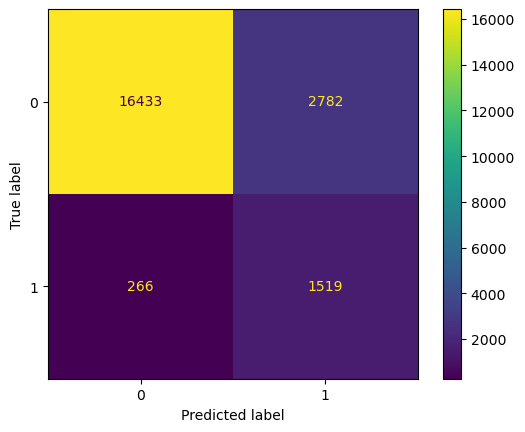

(0.8503617840578854,
 0.8530988351624802,
 0.5791326399852448,
 0.5781518468406931,
 0.843937575030012,
 0.8509803921568627,
 0.6608136561889005,
 0.6638405733764531,
 0.8556938775510204,
 0.8548571428571429,
 0.8567859930857589,
 0.8552172781680979)

In [143]:
bayes = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(-9, 0, 20) 
}

grid_search = GridSearchCV(bayes, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed_df, y_train)

bayes_best = grid_search.best_estimator_
scores_model(X_train_transformed_df, X_test_transformed_df, bayes_best)

**SVC**


Model Performance:
Training Recall Score: 0.8934
Test Recall Score: 0.9042
Training F2 Score: 0.7312
Test F2 Score: 0.7377
Training Specificity Score: 0.8870
Test Specificity Score: 0.8862
Training ROC-AUC: 0.8902
Test ROC-AUC: 0.8952
Training PR-AUC: 0.8186
Test PR-AUC: 0.8236
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8878
Test Confusion Matrix:
 [[17029  2186]
 [  171  1614]]


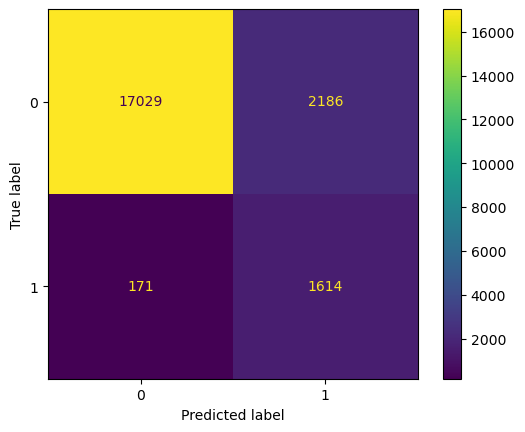

(0.8902137904342065,
 0.8952181965682448,
 0.8186356266208694,
 0.8236332999770399,
 0.8933973589435774,
 0.9042016806722689,
 0.7311561738583667,
 0.7376599634369287,
 0.8875714285714286,
 0.8877619047619048,
 0.8870302219248355,
 0.8862347124642207)

In [144]:
svc = SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced', random_state=32)  
scores_model(X_train_transformed_df, X_test_transformed_df, svc)

**Stacking**  

We chose from the 7 best models from the ones we tested so far to use in stacking and further model evaluation.

In [163]:
def get_stacking():
    
    level0 = list()
    level0.append(('lr', lr_best))
    level0.append(('dtc', dtc_best))
    level0.append(('rf', rf_best))
    level0.append(('bagging', bagging_best))
    level0.append(('gboost', gboost_best))
    level0.append(('xgb', xgb_best))
    #level0.append(('svc', svc))
    level0.append(('bayes', bayes_best))
    
    level1 = lr_best
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [164]:
def get_models():
    
    models = dict()
    models['lr'] = lr_best
    models['dtc'] =dtc_best
    models['rf'] = rf_best
    models['gboost'] = gboost_best
    models['xgb'] = xgb_best
    #models['svc'] = svc
    models['bayes'] = bayes_best
    models['bagging'] = bagging_best
    models['stacking'] = get_stacking()

    return models

A function comparing probably the most important metrics for us - recall and f2 score.

In [158]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=1, random_state=32)
    
    recall_scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
    f2_scores = cross_val_score(model, X, y, scoring=f2_scorer, cv=cv, n_jobs=-1, error_score='raise')
    
    return recall_scores, f2_scores

In [148]:
f2_scorer = make_scorer(fbeta_score, beta=2)

models = get_models()

results_recall, results_f2, names = list(), list(), list()
results_recall_test, results_f2_test= list(), list()


for name, model in models.items():
    recall_scores, f2_scores = evaluate_model(model, X_train_transformed_df, y_train)
    recall_scores_test, f2_scores_test = evaluate_model(model, X_test_transformed_df, y_test)

    
    results_recall.append(recall_scores)
    results_f2.append(f2_scores)
    names.append(name)
    results_recall_test.append(recall_scores_test)
    results_f2_test.append(f2_scores_test)
    
    print(f"{name:8} Recall mean: {np.mean(recall_scores):.3f} std: {np.std(recall_scores):.3f}")
    print(f"{name:8} F2 mean: {np.mean(f2_scores):.3f} std: {np.std(f2_scores):.3f}")
    print(f"{name:8} Recall mean test: {np.mean(recall_scores_test):.3f} std: {np.std(recall_scores_test):.3f}")
    print(f"{name:8} F2 mean test: {np.mean(f2_scores_test):.3f} std: {np.std(f2_scores_test):.3f}")

lr       Recall mean: 0.889 std: 0.011
lr       F2 mean: 0.728 std: 0.010
lr       Recall mean test: 0.895 std: 0.018
lr       F2 mean test: 0.734 std: 0.014
dtc      Recall mean: 0.981 std: 0.003
dtc      F2 mean: 0.604 std: 0.004
dtc      Recall mean test: 0.979 std: 0.008
dtc      F2 mean test: 0.606 std: 0.007
rf       Recall mean: 0.919 std: 0.009
rf       F2 mean: 0.743 std: 0.004
rf       Recall mean test: 0.915 std: 0.020
rf       F2 mean test: 0.753 std: 0.013
gboost   Recall mean: 0.919 std: 0.015
gboost   F2 mean: 0.758 std: 0.009
gboost   Recall mean test: 0.908 std: 0.023
gboost   F2 mean test: 0.768 std: 0.013
xgb      Recall mean: 0.918 std: 0.008
xgb      F2 mean: 0.654 std: 0.006
xgb      Recall mean test: 0.922 std: 0.011
xgb      F2 mean test: 0.657 std: 0.011
bayes    Recall mean: 0.843 std: 0.013
bayes    F2 mean: 0.659 std: 0.011
bayes    Recall mean test: 0.838 std: 0.023
bayes    F2 mean test: 0.663 std: 0.020
bagging  Recall mean: 0.913 std: 0.009
bagging  F2 m

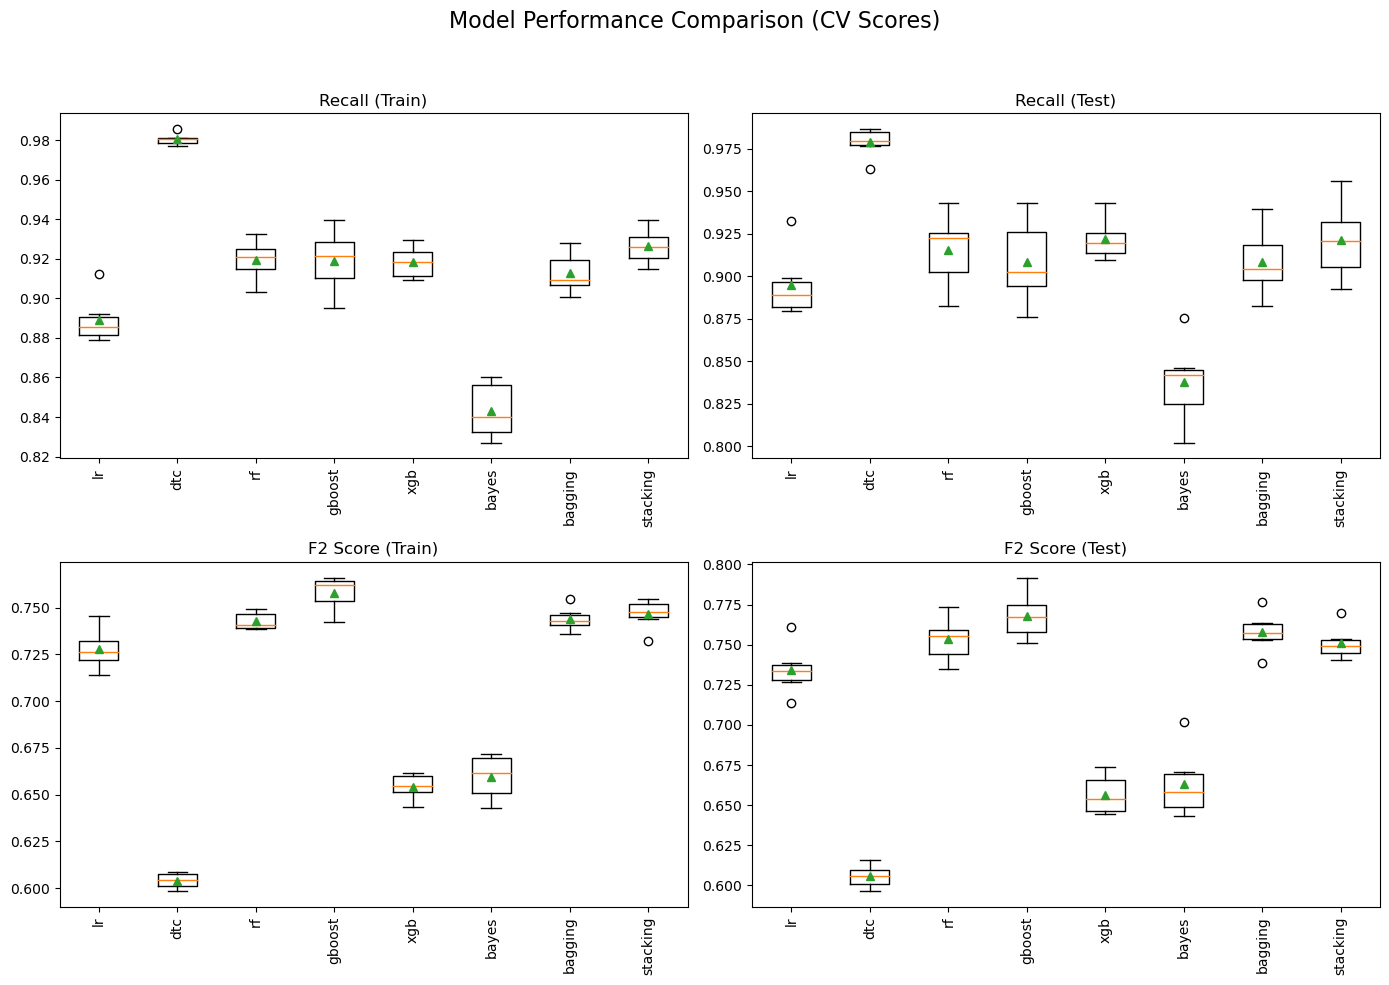

In [149]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Model Performance Comparison (CV Scores)", fontsize=16)

axs[0, 0].boxplot(results_recall, labels=names, showmeans=True)
axs[0, 0].set_title("Recall (Train)")
axs[0, 0].tick_params(axis='x', rotation=90)

axs[0, 1].boxplot(results_recall_test, labels=names, showmeans=True)
axs[0, 1].set_title("Recall (Test)")
axs[0, 1].tick_params(axis='x', rotation=90)

axs[1, 0].boxplot(results_f2, labels=names, showmeans=True)
axs[1, 0].set_title("F2 Score (Train)")
axs[1, 0].tick_params(axis='x', rotation=90)

axs[1, 1].boxplot(results_f2_test, labels=names, showmeans=True)
axs[1, 1].set_title("F2 Score (Test)")
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Looking at these plot there are a few modes that perform worse than other:  
- DecisionTreeClassifier  
- Gaussian Naive Bayes 
- XGBoost

lr

Model Performance:
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Training F2 Score: 0.7298
Test F2 Score: 0.7347
Training Specificity Score: 0.8873
Test Specificity Score: 0.8848
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


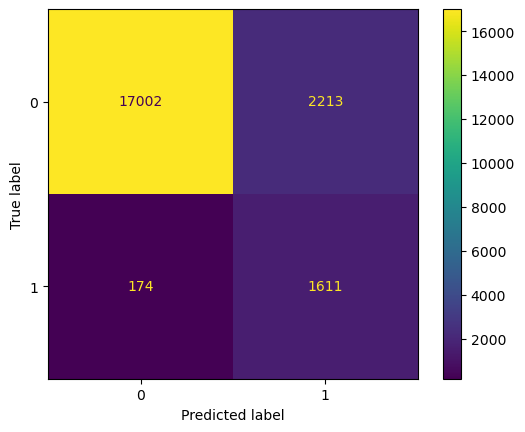

dtc

Model Performance:
Training Recall Score: 0.9806
Test Recall Score: 0.9787
Training F2 Score: 0.6040
Test F2 Score: 0.6055
Training Specificity Score: 0.7086
Test Specificity Score: 0.7118
Training ROC-AUC: 0.8446
Test ROC-AUC: 0.8452
Training PR-AUC: 0.5856
Test PR-AUC: 0.5830
Training Accuracy Score: 0.7317
Test Accuracy Score: 0.7345
Test Confusion Matrix:
 [[13677  5538]
 [   38  1747]]


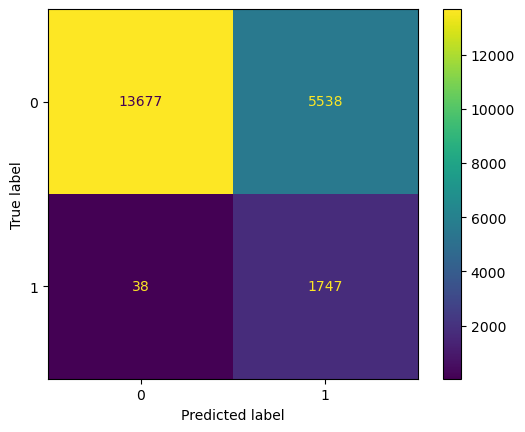

rf

Model Performance:
Training Recall Score: 0.9229
Test Recall Score: 0.9255
Training F2 Score: 0.7436
Test F2 Score: 0.7458
Training Specificity Score: 0.8809
Test Specificity Score: 0.8811
Training ROC-AUC: 0.9019
Test ROC-AUC: 0.9033
Training PR-AUC: 0.8700
Test PR-AUC: 0.8798
Training Accuracy Score: 0.8844
Test Accuracy Score: 0.8849
Test Confusion Matrix:
 [[16931  2284]
 [  133  1652]]


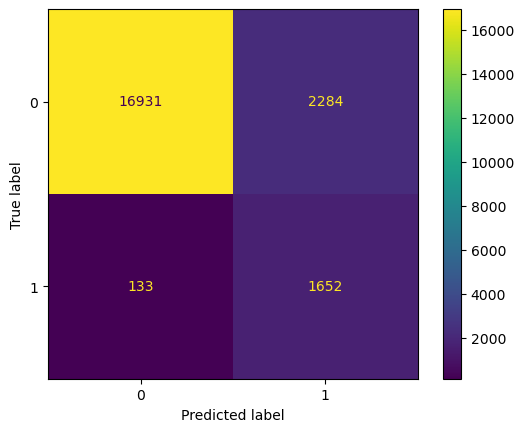

gboost

Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


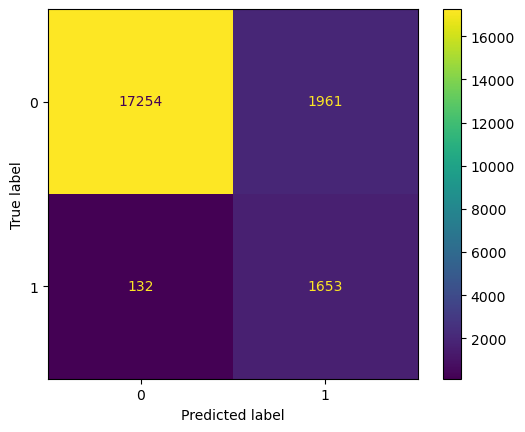

xgb

Model Performance:
Training Recall Score: 0.9188
Test Recall Score: 0.9255
Training F2 Score: 0.6552
Test F2 Score: 0.6569
Training Specificity Score: 0.8055
Test Specificity Score: 0.8032
Training ROC-AUC: 0.8622
Test ROC-AUC: 0.8643
Training PR-AUC: 0.7618
Test PR-AUC: 0.7645
Training Accuracy Score: 0.8151
Test Accuracy Score: 0.8136
Test Confusion Matrix:
 [[15433  3782]
 [  133  1652]]


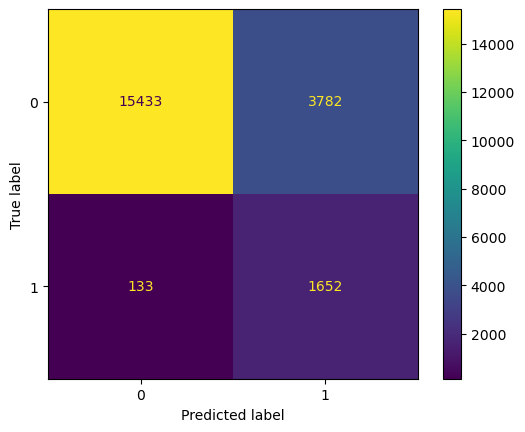

bayes

Model Performance:
Training Recall Score: 0.8439
Test Recall Score: 0.8510
Training F2 Score: 0.6608
Test F2 Score: 0.6638
Training Specificity Score: 0.8568
Test Specificity Score: 0.8552
Training ROC-AUC: 0.8504
Test ROC-AUC: 0.8531
Training PR-AUC: 0.5791
Test PR-AUC: 0.5782
Training Accuracy Score: 0.8557
Test Accuracy Score: 0.8549
Test Confusion Matrix:
 [[16433  2782]
 [  266  1519]]


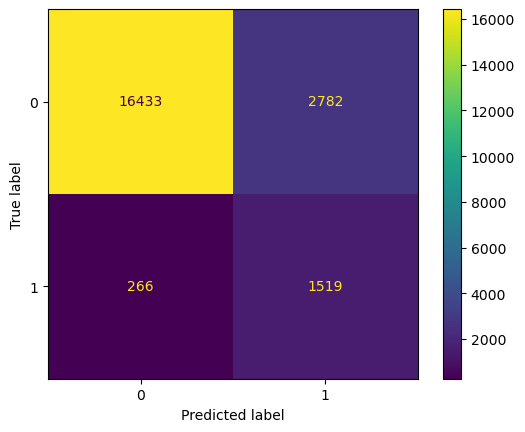

bagging

Model Performance:
Training Recall Score: 0.9184
Test Recall Score: 0.9244
Training F2 Score: 0.7468
Test F2 Score: 0.7515
Training Specificity Score: 0.8857
Test Specificity Score: 0.8861
Training ROC-AUC: 0.9020
Test ROC-AUC: 0.9053
Training PR-AUC: 0.8707
Test PR-AUC: 0.8800
Training Accuracy Score: 0.8885
Test Accuracy Score: 0.8894
Test Confusion Matrix:
 [[17027  2188]
 [  135  1650]]


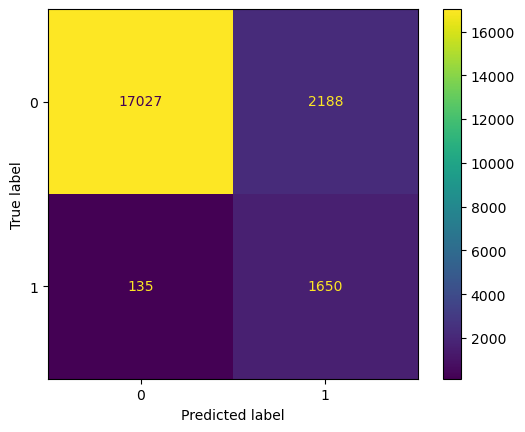

stacking

Model Performance:
Training Recall Score: 0.9388
Test Recall Score: 0.9361
Training F2 Score: 0.7547
Test F2 Score: 0.7528
Training Specificity Score: 0.8810
Test Specificity Score: 0.8810
Training ROC-AUC: 0.9099
Test ROC-AUC: 0.9086
Training PR-AUC: 0.8802
Test PR-AUC: 0.8839
Training Accuracy Score: 0.8859
Test Accuracy Score: 0.8857
Test Confusion Matrix:
 [[16928  2287]
 [  114  1671]]


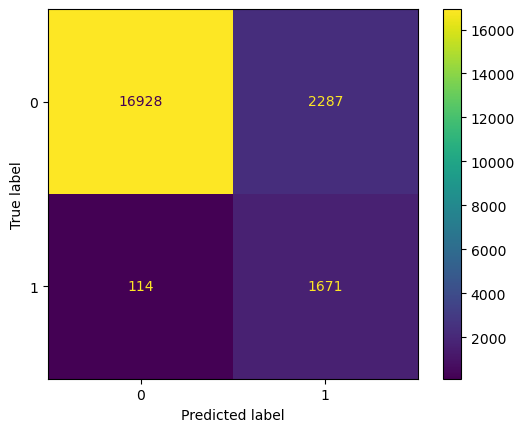

In [150]:
results_train = []
results_test = []

for name, model in models.items():
    print(name)
    metrics = scores_model(X_train_transformed_df, X_test_transformed_df, model)
    
    (train_roc_auc, test_roc_auc, 
     train_pr_auc, test_pr_auc, 
     train_recall, test_recall, 
     train_f2, test_f2, 
     train_acc, test_acc, 
     train_spec, test_spec) = metrics
    
    results_train.extend([
        {'Model': name, 'Metric': 'ROC-AUC', 'Score': train_roc_auc},
        {'Model': name, 'Metric': 'PR-AUC', 'Score': train_pr_auc},
        {'Model': name, 'Metric': 'Recall', 'Score': train_recall},
        {'Model': name, 'Metric': 'F2', 'Score': train_f2},
        {'Model': name, 'Metric': 'Accuracy', 'Score': train_acc},
        {'Model': name, 'Metric': 'Specificity', 'Score': train_spec}
    ])
    
    results_test.extend([
        {'Model': name, 'Metric': 'ROC-AUC', 'Score': test_roc_auc},
        {'Model': name, 'Metric': 'PR-AUC', 'Score': test_pr_auc},
        {'Model': name, 'Metric': 'Recall', 'Score': test_recall},
        {'Model': name, 'Metric': 'F2', 'Score': test_f2},
        {'Model': name, 'Metric': 'Accuracy', 'Score': test_acc},
        {'Model': name, 'Metric': 'Specificity', 'Score': test_spec}
    ])


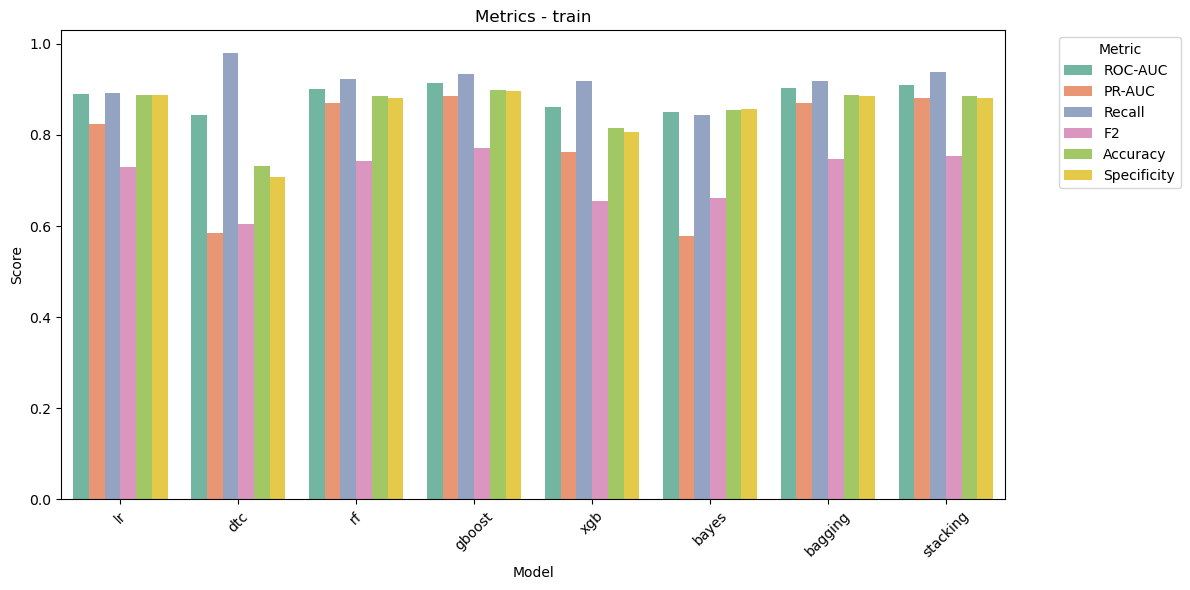

In [151]:
df_train = pd.DataFrame(results_train)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_train, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title("Metrics - train")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


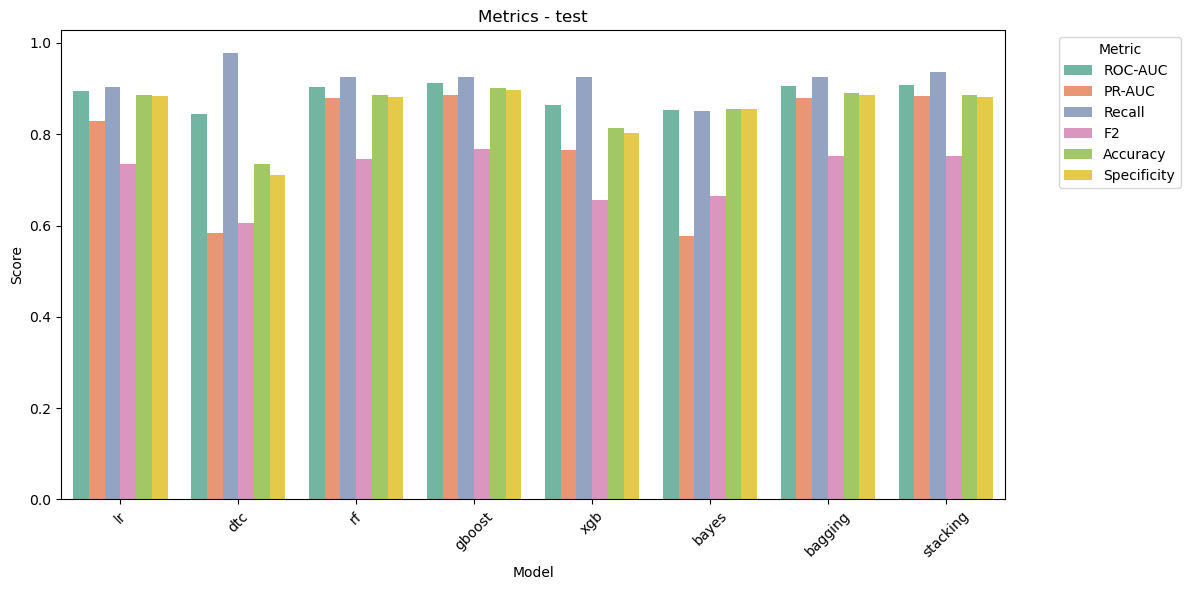

In [152]:
df_test = pd.DataFrame(results_test)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_test, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title("Metrics - test")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

From our modelling we did so far we can favour:
- Stacking
- Bagging
- GBoost
- Random Forest (considering we already did a lot of hyperparameter tuning, there may not be a lot of room for improvement)
  
After validation we decided to continue with gboost and stacking models. They have the best perforamnce on training, testing and validation data. Also there are still hyperparameters to tune and room for those models to improve.